<a href="https://colab.research.google.com/github/Yoshani/Pump-It-Up/blob/master/Pump_It_Up_Post_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost
!pip install category_encoders
!pip install eli5
!pip install pdpbox
!pip install shap

In [ ]:
import numpy as np
import pandas as pd
import pandas_profiling
from sklearn import preprocessing
import datetime as dt
from numpy import mean
from numpy import std
from sklearn.decomposition import PCA

# plotting
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import shap

# encoders
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce

# training
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

# classifiers
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost.sklearn import XGBClassifier

# post processing
from sklearn.inspection import plot_partial_dependence
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox import pdp, get_dataset, info_plots

In [ ]:
features_df = pd.read_csv(
    "/content/drive/MyDrive/PumpItUp/TrainingSet.csv", 
    index_col="id",
    low_memory=False
)
labels_df = pd.read_csv(
    "/content/drive/MyDrive/PumpItUp/TrainingLabels.csv", 
    index_col="id"
)

In [ ]:
X = features_df.copy()
y = labels_df.copy()

df=X.copy()

df.drop(['recorded_by', 'amount_tsh', 'num_private', 'scheme_name', 'extraction_type','extraction_type_group', 'payment_type', 
         'quantity_group', 'source_type', 'waterpoint_type_group', 'region', 'wpt_name', 'subvillage', 'ward'], axis=1, inplace=True)

## Missing values
df.loc[df['construction_year'] == 0,'construction_year'] = np.nan
df['funder'] = df['funder'].fillna("Unknown")
df['installer'] = df['installer'].fillna(X['installer'].mode()[0])
df['population'] = df['population'].fillna(df.groupby('region_code')['population'].transform('median'))
df['public_meeting'] = df['public_meeting'].fillna(True)
df['scheme_management'] = df['scheme_management'].fillna(X['scheme_management'].mode()[0])
df['permit'] = df['permit'].fillna("Unknown")
df['construction_year'] = df['construction_year'].fillna(1950)

df.loc[df['longitude'] == 0, ['longitude', 'latitude']] = np.nan
df["longitude"] = df.groupby("region_code").transform(lambda x: x.fillna(x.mean())).longitude
df["latitude"] = df.groupby("region_code").transform(lambda x: x.fillna(x.mean())).latitude

df.loc[df['gps_height'] == 0, 'gps_height'] = np.nan
df["gps_height"] = df.groupby("region_code").transform(lambda x: x.fillna(x.mean())).gps_height

df=df.fillna(df.mean())

## Feature Engineering
df['operation_time']=df.date_recorded.apply(pd.to_datetime)-df.construction_year.apply(lambda x: pd.to_datetime(x,format='%Y'))
df['operation_time']=df.operation_time.apply(lambda x: float(x.days)/ (365.25*24*60*60*1e9))
df.loc[df['operation_time'] < 0,df.columns=='operation_time'] = 63.92060232717317

df['logPopulation'] = df.population.apply(np.log1p)
'''df.drop(['population'], axis=1, inplace=True)''' # keep population for comparison

df['year']=pd.to_datetime(df.date_recorded).dt.year
df['month']=pd.to_datetime(df.date_recorded).dt.month
df['day']=pd.to_datetime(df.date_recorded).dt.day
'''df.drop(['date_recorded'], axis=1, inplace=True)''' # keep date for comparison

## Encode
enc = ce.BinaryEncoder(cols=['funder', 'installer', 'lga']).fit(df)
df = enc.transform(df)
df.drop(['funder_0', 'lga_0', 'installer_0'], axis=1, inplace=True)

permit_map = {
    "Unknown": 0,
    False: 1,
    True: 2
  }

df['permit'] = df['permit'].map(permit_map)

df['public_meeting'] = df['public_meeting'].astype(int)

le_df = df.select_dtypes(["object", "category"])
le_cols = le_df.loc[:, [col for col in le_df.columns if (le_df[col].nunique() > 10)]].columns.tolist()

for col in le_cols:
  df[col] = LabelEncoder().fit_transform(df[col])

one_hot_cols = df.select_dtypes(["object", "category"]).columns.tolist()
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(df[one_hot_cols]))
OH_cols.index = df.index
OH_cols.columns = OH_encoder.get_feature_names(one_hot_cols)
num_df = df.drop(one_hot_cols, axis=1)
df = pd.concat([num_df, OH_cols], axis=1)

## Normalization
# df=(df - df.min())/(df.max() - df.min())

In [ ]:
# label encode y for intepretability
label_map = {
    "functional": 0,
    "functional needs repair": 1,
    "non functional": 2
  }

y['status_group'] = y['status_group'].map(label_map)

In [ ]:
X = df[:len(features_df)]
X_test = df[len(features_df):]
X_train, X_valid, y_train, y_valid = train_test_split(X, y.status_group, test_size=0.1, random_state=10)

In [ ]:
modelRFC = RandomForestClassifier(n_estimators=1500, min_samples_split=6, criterion='gini', max_depth=30)

modelETC = ExtraTreesClassifier(n_estimators=2000, min_samples_split=6)

modelXGB = XGBClassifier(objective = 'multi:softmax', 
                      num_class = 3, maximize = False, eval_metric = 'merror', eta = 0.1,
                      max_depth = 14, colsample_bytree = 0.4, num_boost_round=1000, nfold=4, early_stopping_rounds=10)

modelRFC.fit(X_train, y_train)
modelETC.fit(X_train, y_train)
modelXGB.fit(X_train, y_train)

# Feature importance

Random Forest

Text(0.5, 0, 'Random Forest Feature Importance')

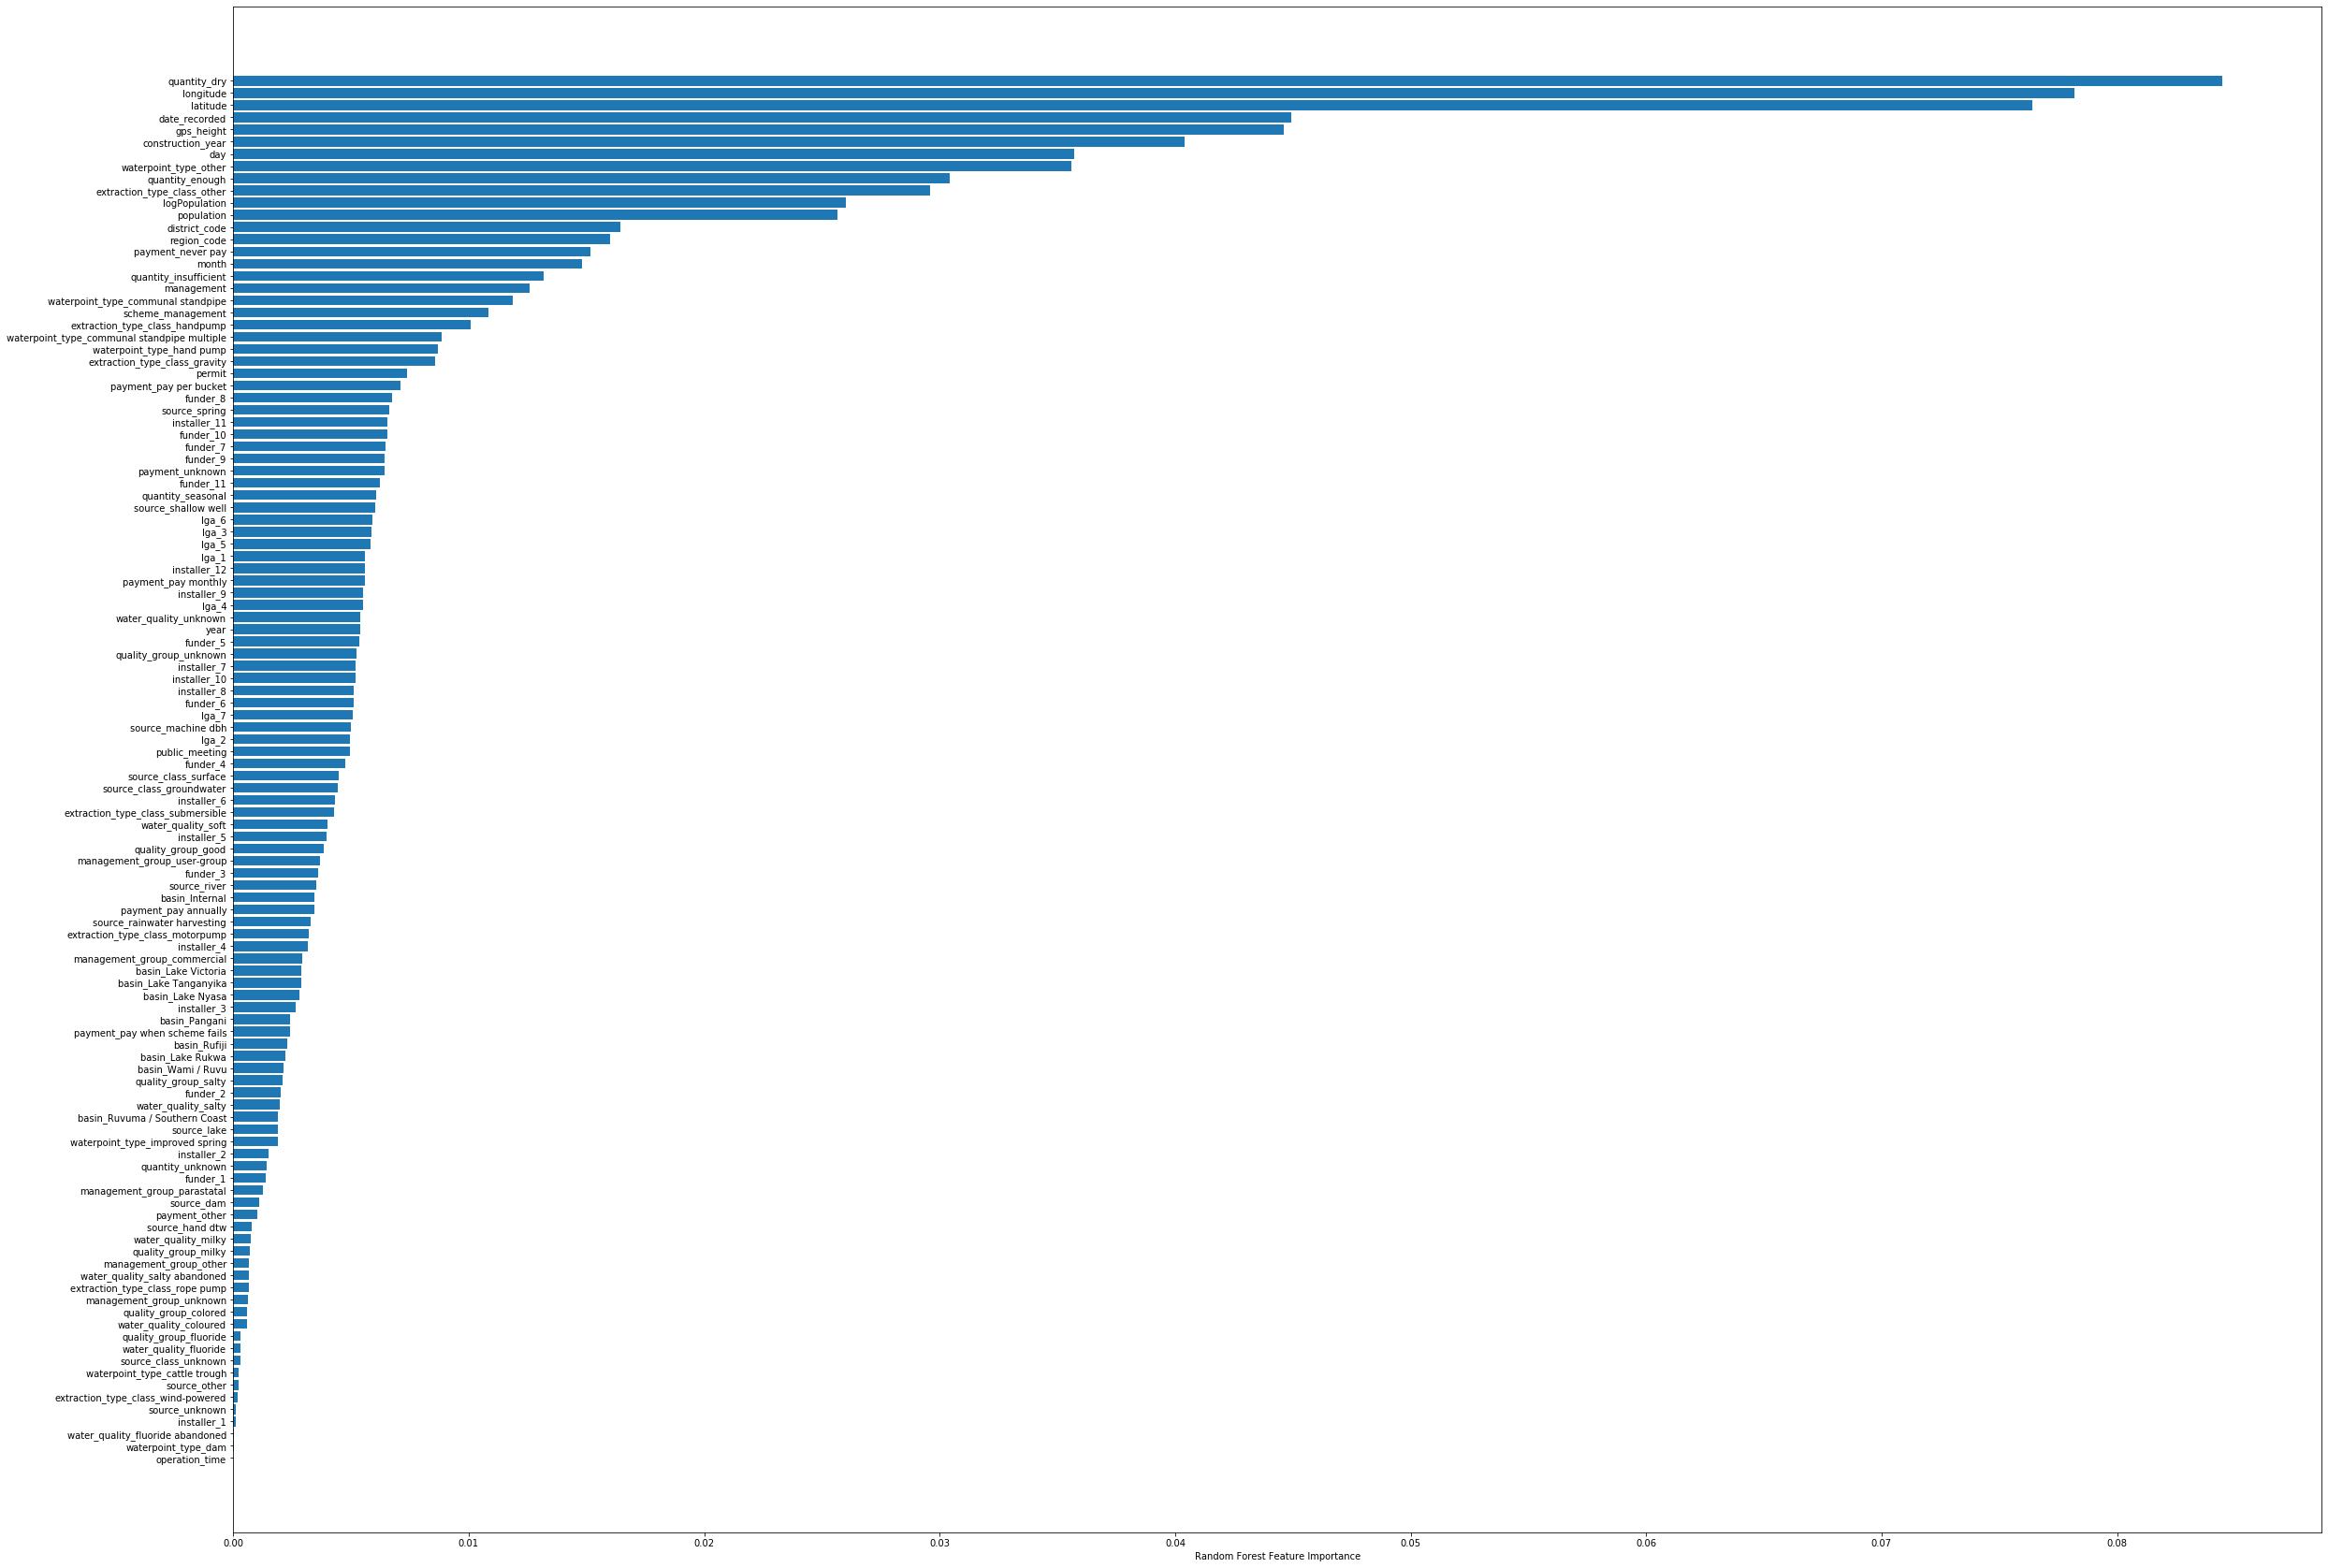

In [ ]:
plt.subplots(figsize=(40, 30))
sorted_idx = modelRFC.feature_importances_.argsort()
plt.barh(X_train.columns.values[sorted_idx], modelRFC.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [ ]:
# permutation importance
perm = PermutationImportance(modelRFC, random_state=1).fit(X_valid, y_valid)
eli5.show_weights(perm, feature_names = X_valid.columns.tolist())

Weight,Feature
0.0638 ± 0.0046,quantity_dry
0.0083 ± 0.0024,payment_never pay
0.0081 ± 0.0024,quantity_enough
0.0073 ± 0.0026,waterpoint_type_other
0.0063 ± 0.0020,construction_year
0.0061 ± 0.0022,latitude
0.0045 ± 0.0028,longitude
0.0027 ± 0.0027,gps_height
0.0025 ± 0.0028,extraction_type_class_other
0.0023 ± 0.0012,payment_unknown


Extra Trees

Text(0.5, 0, 'Extra Trees Feature Importance')

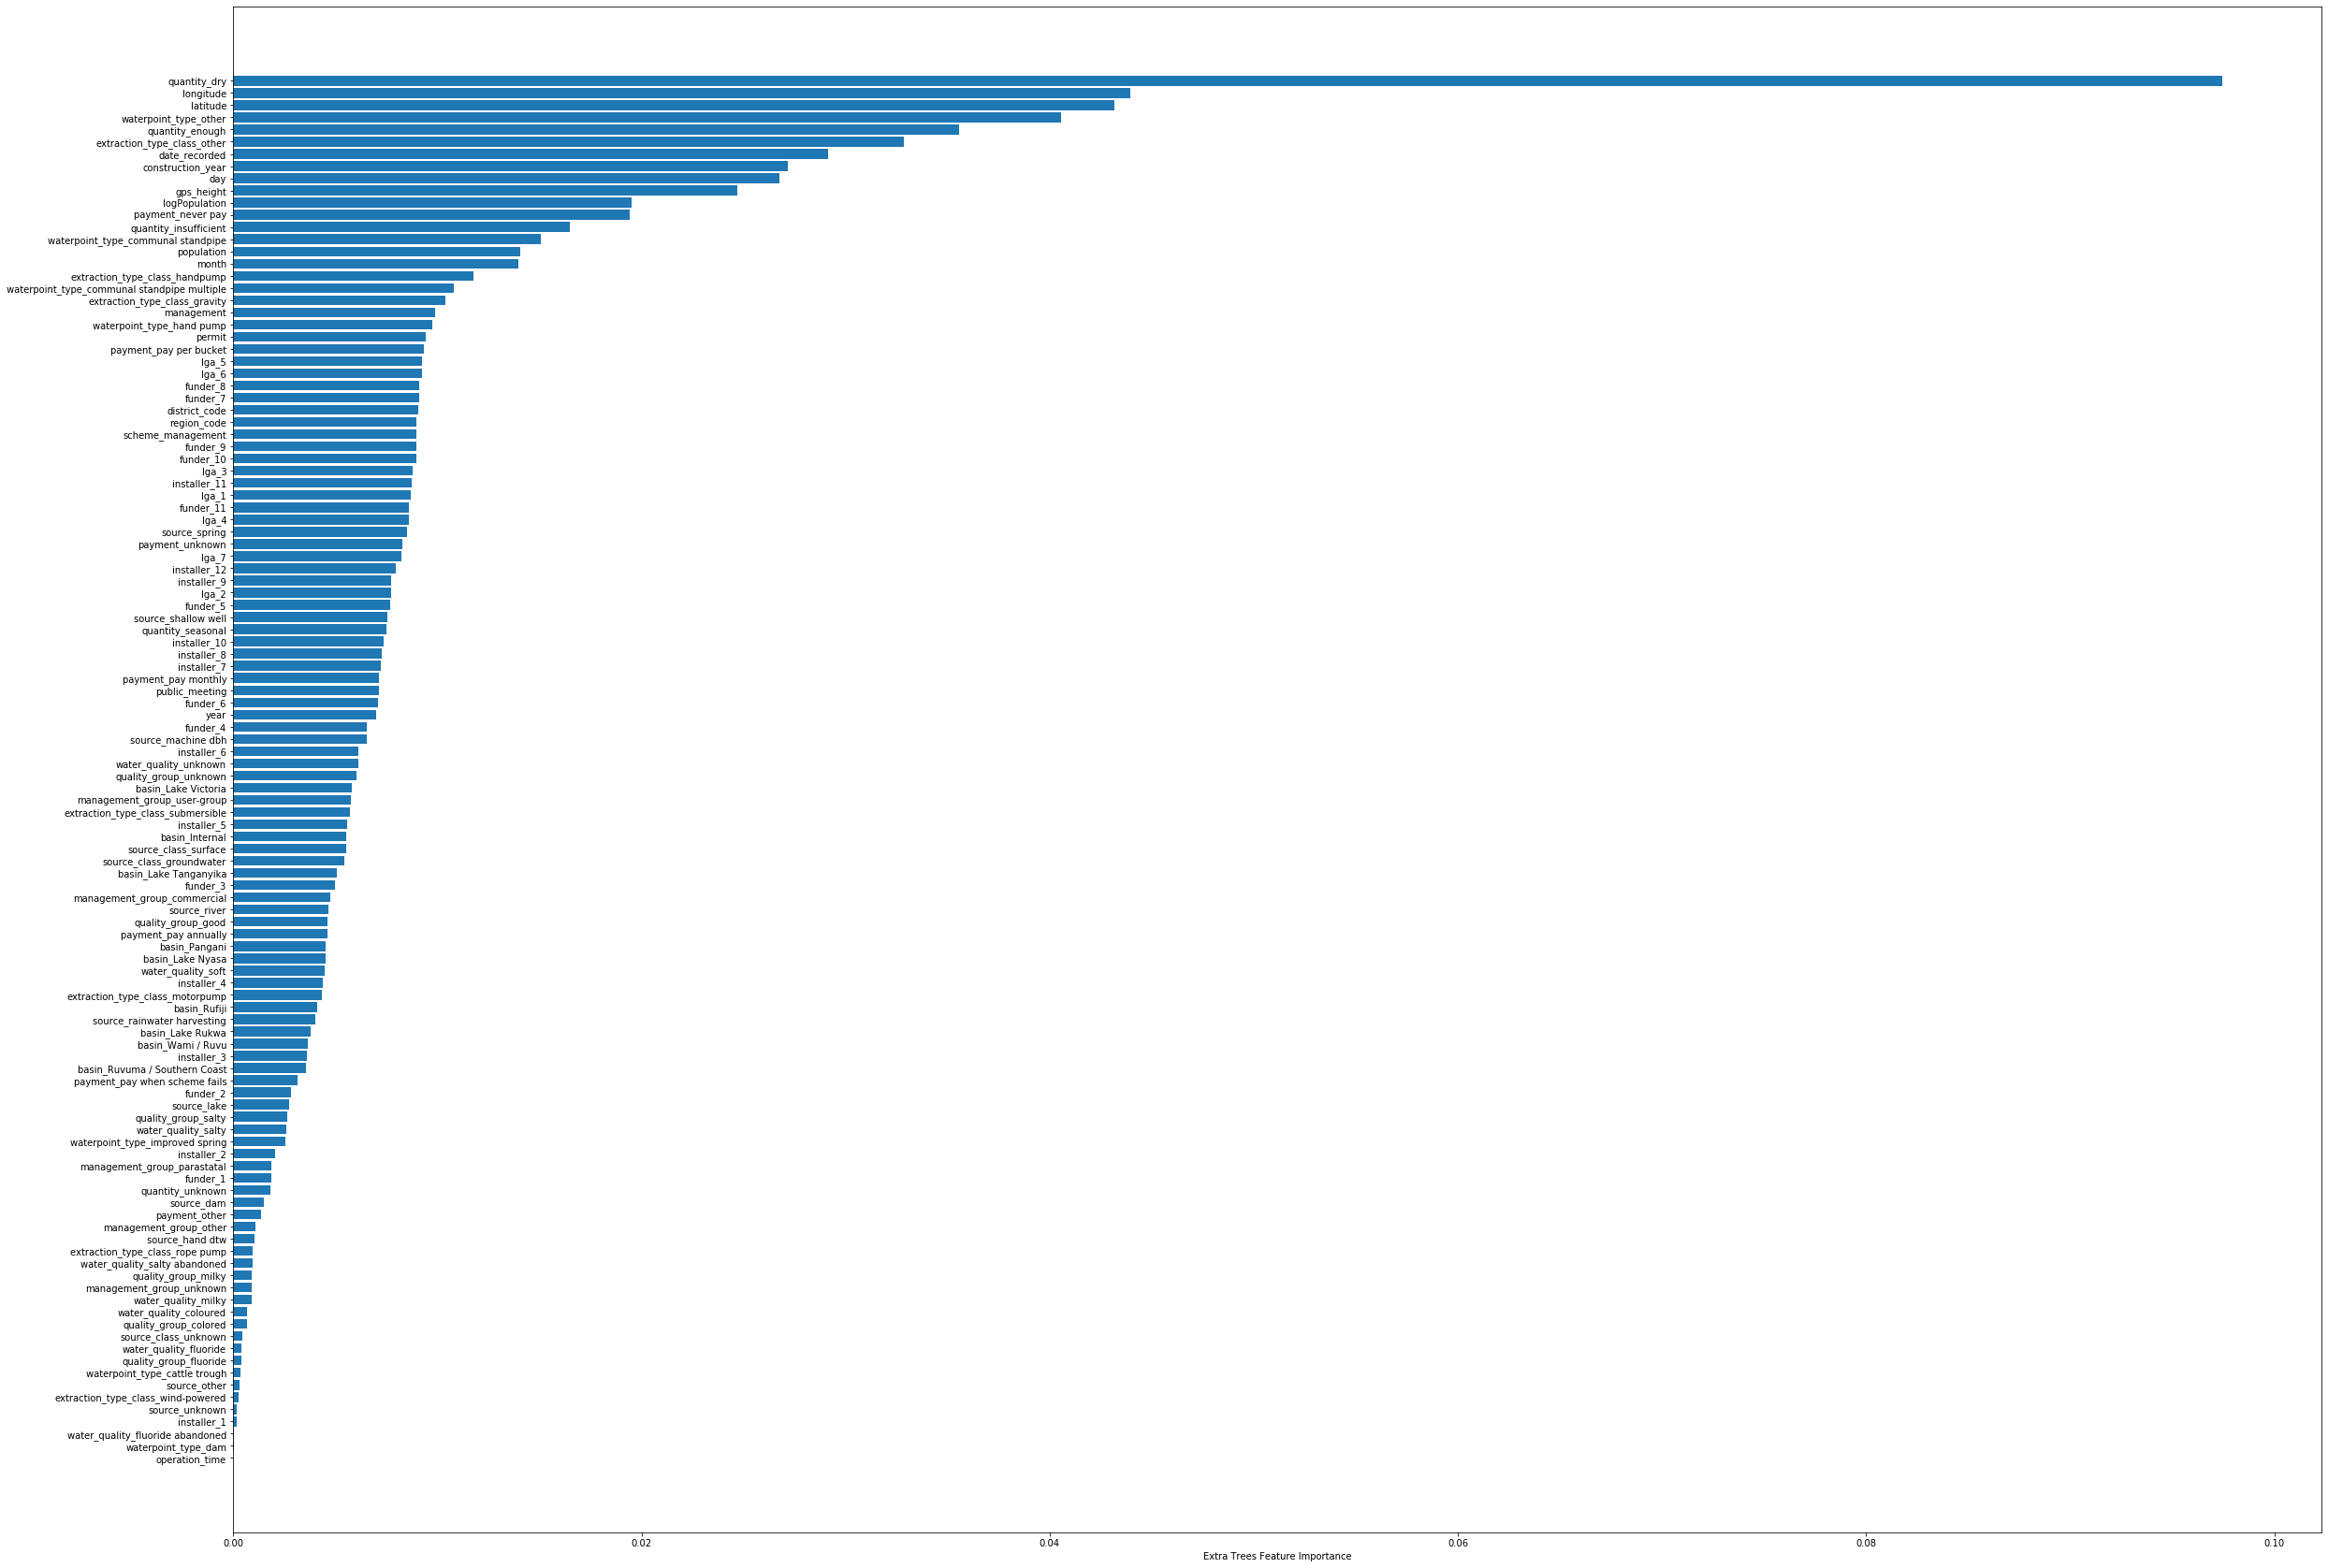

In [ ]:
plt.subplots(figsize=(40, 30))
sorted_idx = modelETC.feature_importances_.argsort()
plt.barh(X_train.columns.values[sorted_idx], modelETC.feature_importances_[sorted_idx])
plt.xlabel("Extra Trees Feature Importance")

In [ ]:
# permutation importance
perm = PermutationImportance(modelETC, random_state=1).fit(X_valid, y_valid)
eli5.show_weights(perm, feature_names = X_valid.columns.tolist())

Weight,Feature
0.0633 ± 0.0037,quantity_dry
0.0134 ± 0.0051,payment_never pay
0.0130 ± 0.0032,quantity_enough
0.0094 ± 0.0018,waterpoint_type_other
0.0046 ± 0.0023,extraction_type_class_other
0.0040 ± 0.0008,latitude
0.0040 ± 0.0025,construction_year
0.0023 ± 0.0009,waterpoint_type_hand pump
0.0021 ± 0.0013,day
0.0019 ± 0.0007,payment_unknown


XGBoost

Text(0.5, 0, 'XGBoost Feature Importance')

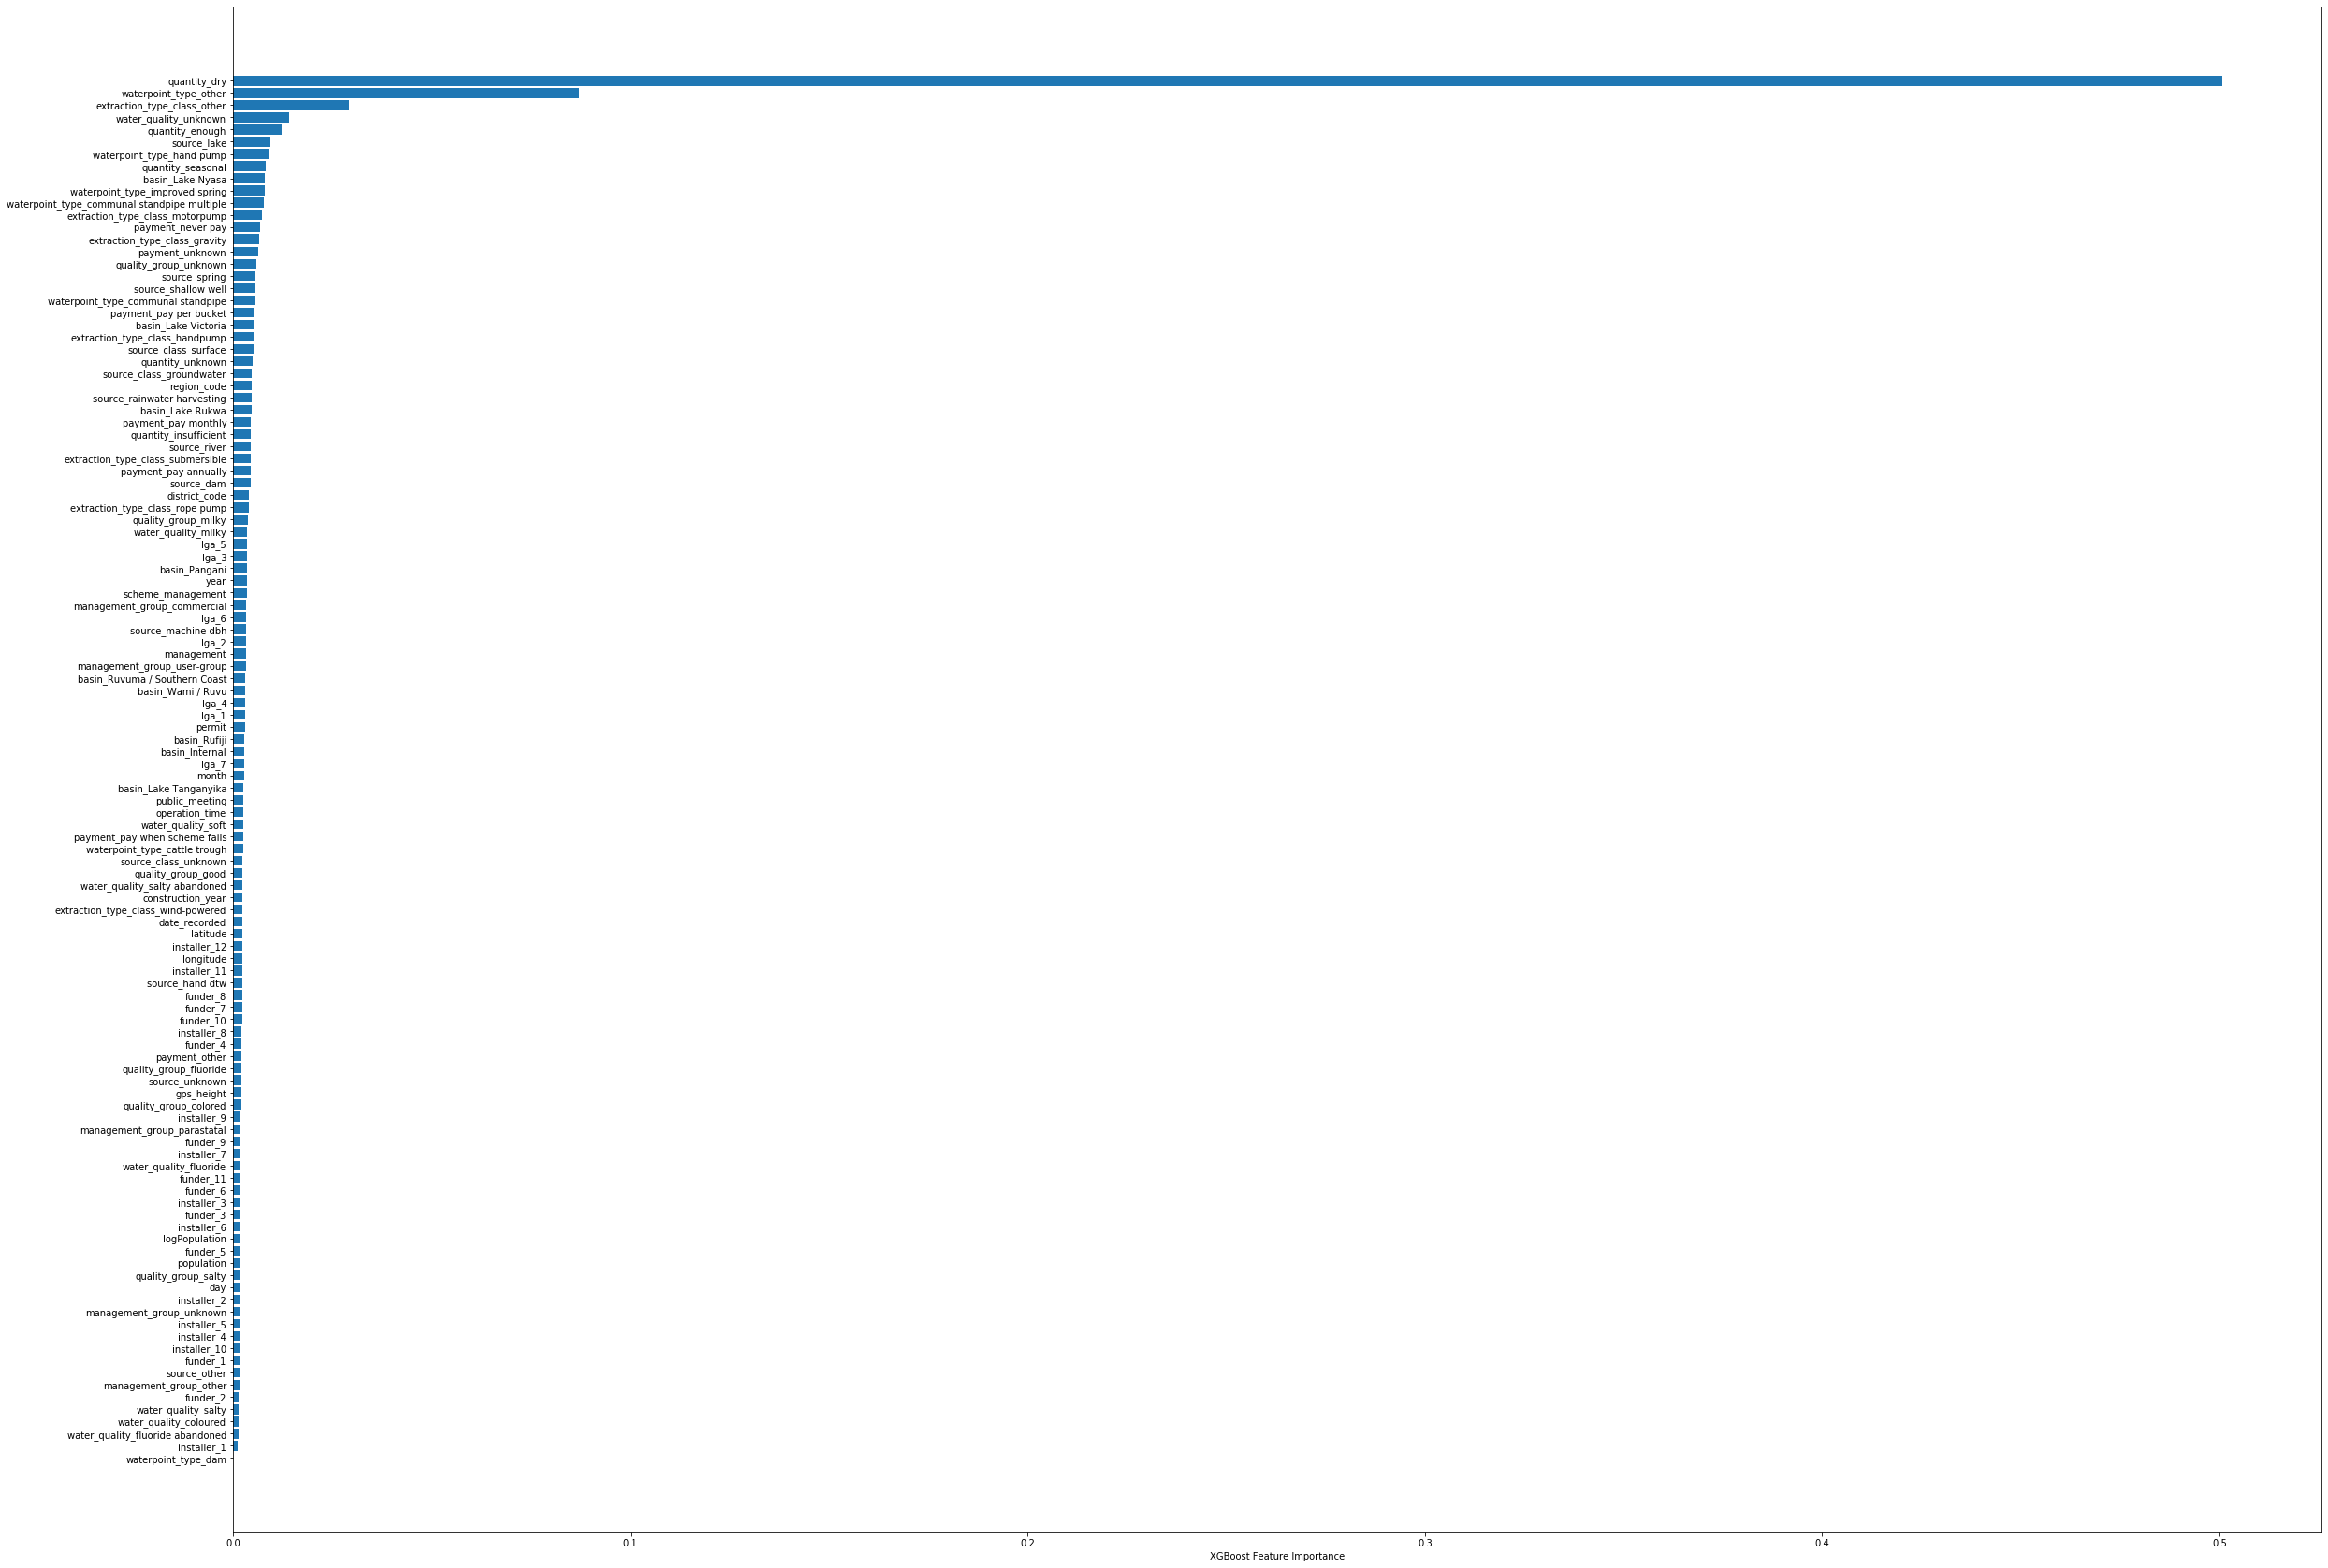

In [ ]:
plt.subplots(figsize=(40, 30))
sorted_idx = modelXGB.feature_importances_.argsort()
plt.barh(X_train.columns.values[sorted_idx], modelXGB.feature_importances_[sorted_idx])
plt.xlabel("XGBoost Feature Importance")

In [ ]:
# permutation importance
perm = PermutationImportance(modelXGB, random_state=1).fit(X_valid, y_valid)
eli5.show_weights(perm, feature_names = X_valid.columns.tolist())

Weight,Feature
0.0592 ± 0.0034,quantity_dry
0.0202 ± 0.0026,waterpoint_type_other
0.0135 ± 0.0022,quantity_enough
0.0123 ± 0.0043,payment_never pay
0.0084 ± 0.0034,operation_time
0.0080 ± 0.0026,latitude
0.0060 ± 0.0031,longitude
0.0051 ± 0.0021,waterpoint_type_hand pump
0.0043 ± 0.0015,extraction_type_class_other
0.0042 ± 0.0023,extraction_type_class_handpump


Water quantity being dry seems to highly affect the prediction of all the models. Longitude seems to matter more than latitude

# Partial Dependence Plots

Longitude and latitude

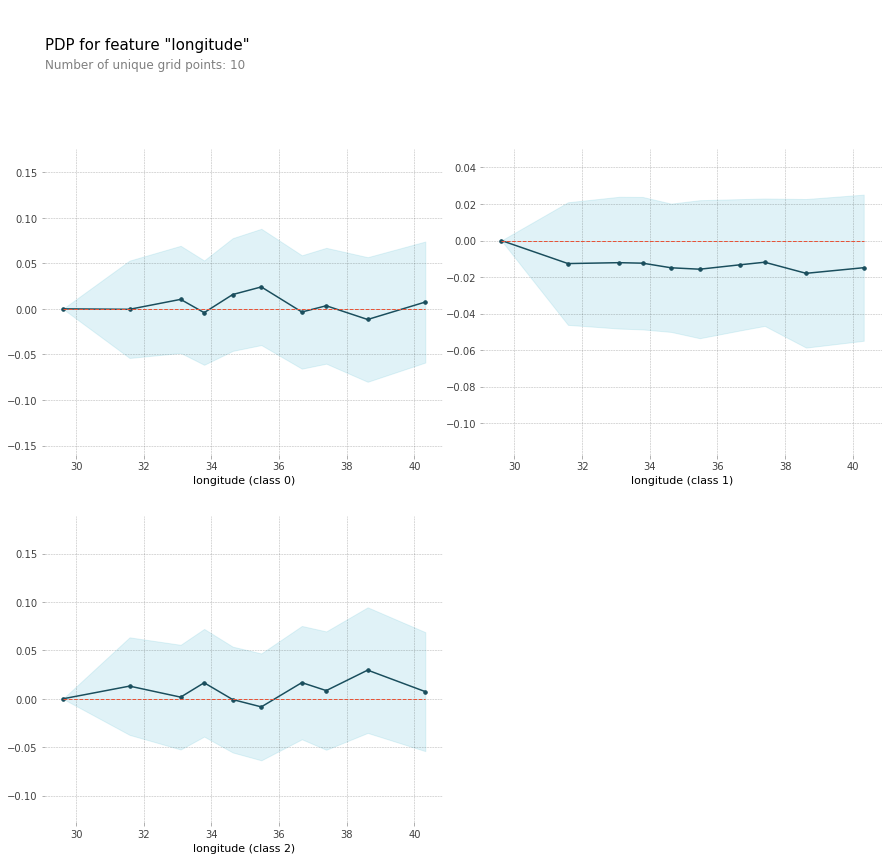

In [ ]:
pdp_goals = pdp.pdp_isolate(model=modelXGB, dataset=X_valid, model_features=X_valid.columns.tolist(), feature='longitude')
pdp.pdp_plot(pdp_goals, 'longitude')
plt.show()

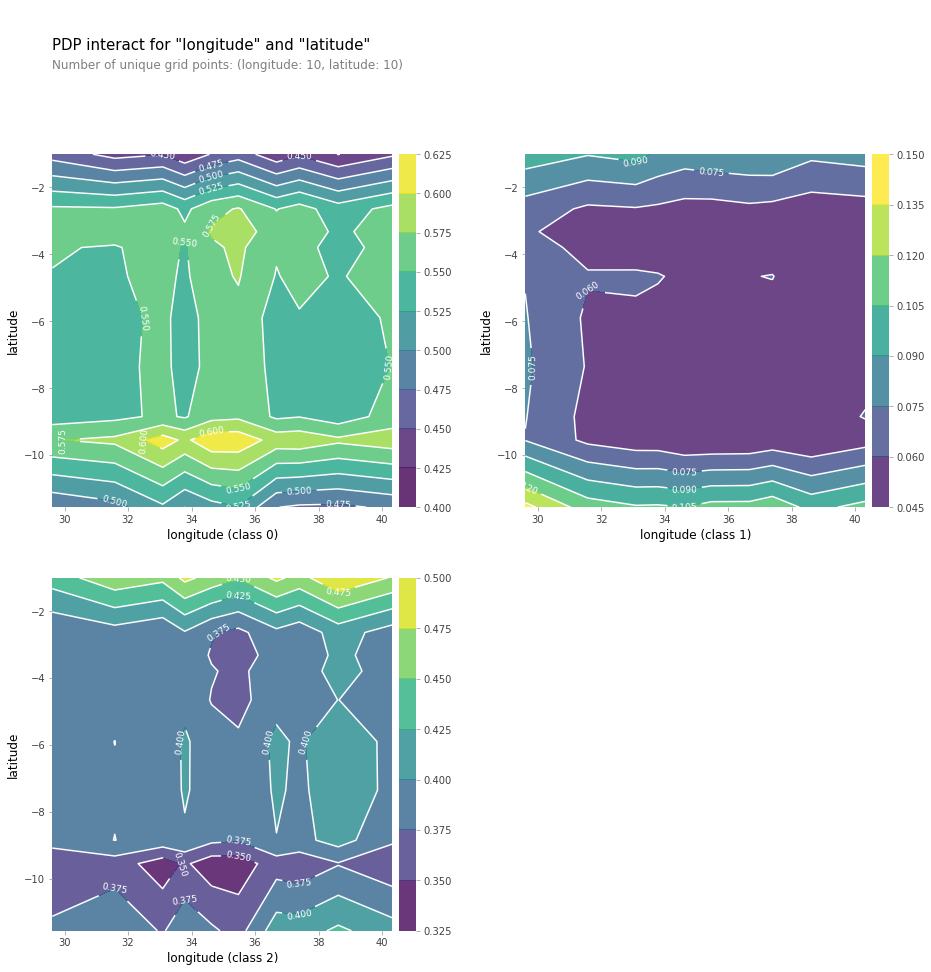

In [ ]:
# 2D plot
features_to_plot = ['longitude', 'latitude']
inter1  =  pdp.pdp_interact(model=modelXGB, dataset=X_valid, model_features=X_valid.columns.tolist(), features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

There doesn't seem to be an exact relationship among the longitude/latitude values and the changes in prediction

GPS height

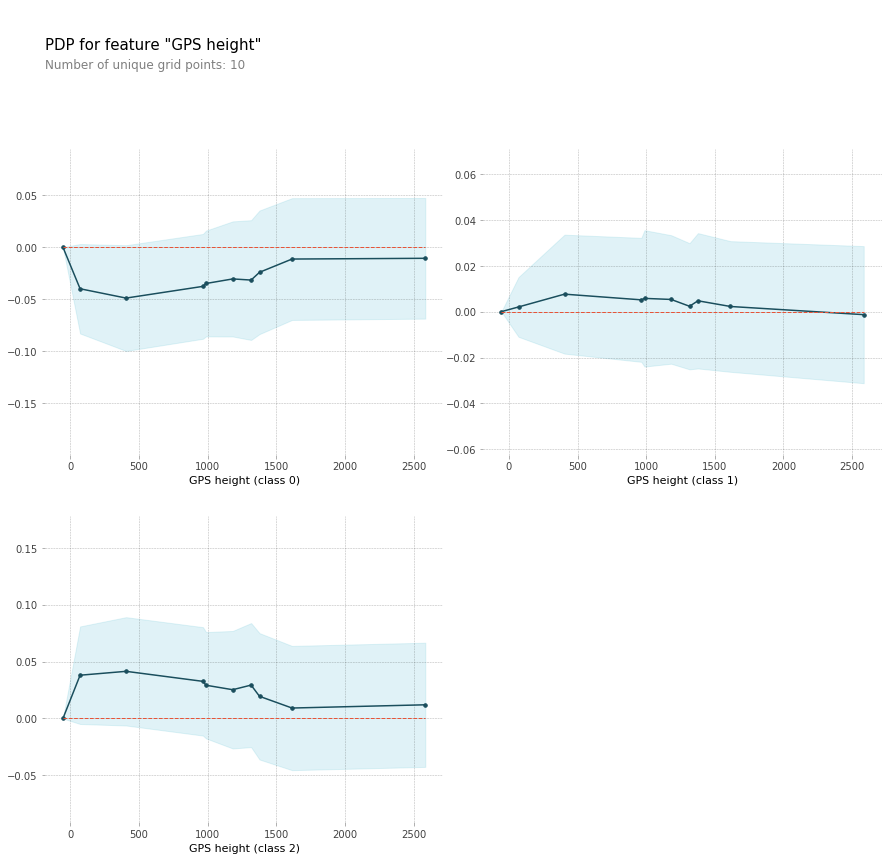

In [ ]:
pdp_goals = pdp.pdp_isolate(model=modelXGB, dataset=X_valid, model_features=X_valid.columns.tolist(), feature='gps_height')

pdp.pdp_plot(pdp_goals, 'GPS height')
plt.show()

*   Up to about gps height 500 the model's likeliness to predict functional decreases, but increases after that
*   There doesn't seem to be much effect on predicting functional but needs repair
*   Predicting non functional is as expected, roughly the reverse of predicting functional





Operation time

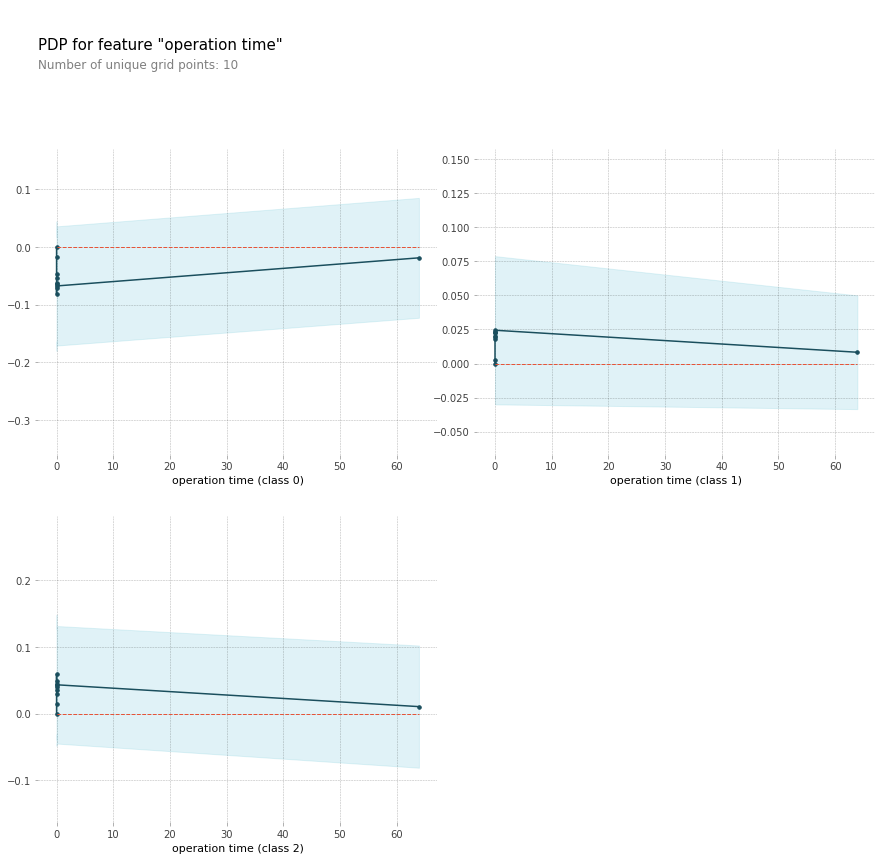

In [ ]:
pdp_goals = pdp.pdp_isolate(model=modelXGB, dataset=X_valid, model_features=X_valid.columns.tolist(), feature='operation_time')

pdp.pdp_plot(pdp_goals, 'operation time')
plt.show()

If operation time is more:
*   it becomes more likely to predict it's functional
*   it becomes less likely to predict it's functional but needs repair
*   it becomes less likely to predict it's non functional





If it has more operational time, it should mostly be functional

Population

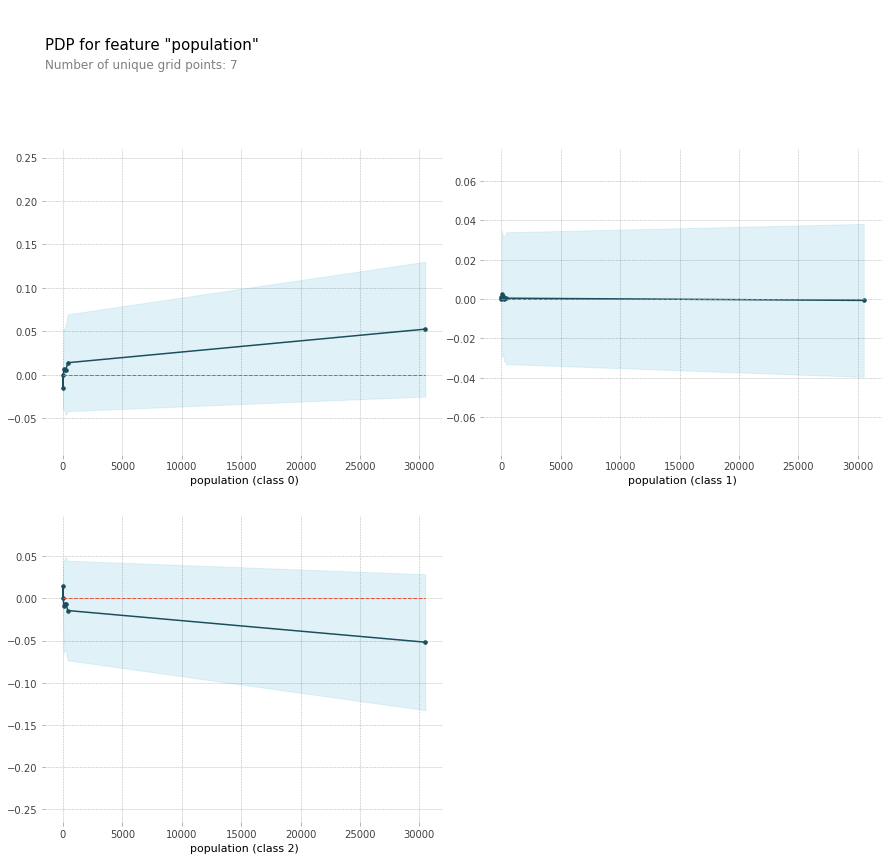

In [ ]:
pdp_goals = pdp.pdp_isolate(model=modelXGB, dataset=X_valid, model_features=X_valid.columns.tolist(), feature='population')

pdp.pdp_plot(pdp_goals, 'population')
plt.show()

When population increases, chances of:

*   being functional increases
*   being non functional decreases

Population has no effect on predicting if it is functional but needs repair

Construction year

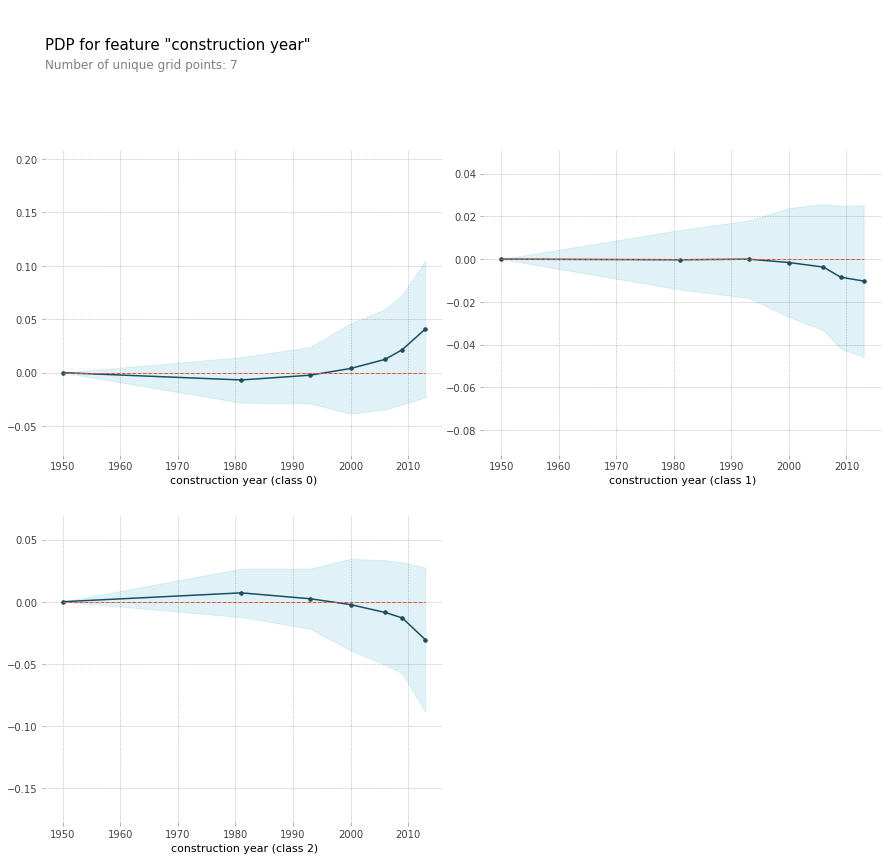

In [ ]:
pdp_goals = pdp.pdp_isolate(model=modelXGB, dataset=X_valid, model_features=X_valid.columns.tolist(), feature='construction_year')

pdp.pdp_plot(pdp_goals, 'construction year')
plt.show()

*   If the pipe was built after around 2000, it becomes more likely that the model predicts it is functional
*   Similarly for pipes built after around 2000, the pipes are less likely to be predicted functional needs repair or non functional


# SHAP

Summary Plots

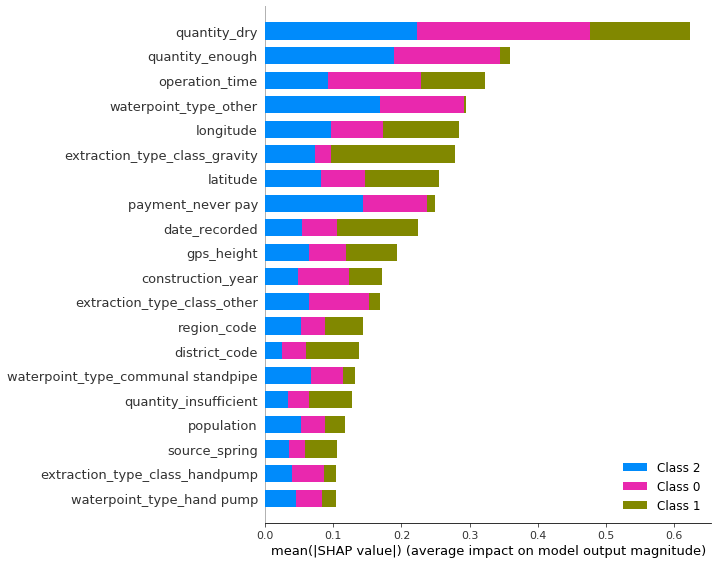

In [ ]:
explainer = shap.TreeExplainer(modelXGB)
shap_values = explainer.shap_values(X_valid)
shap.summary_plot(shap_values, X_valid)

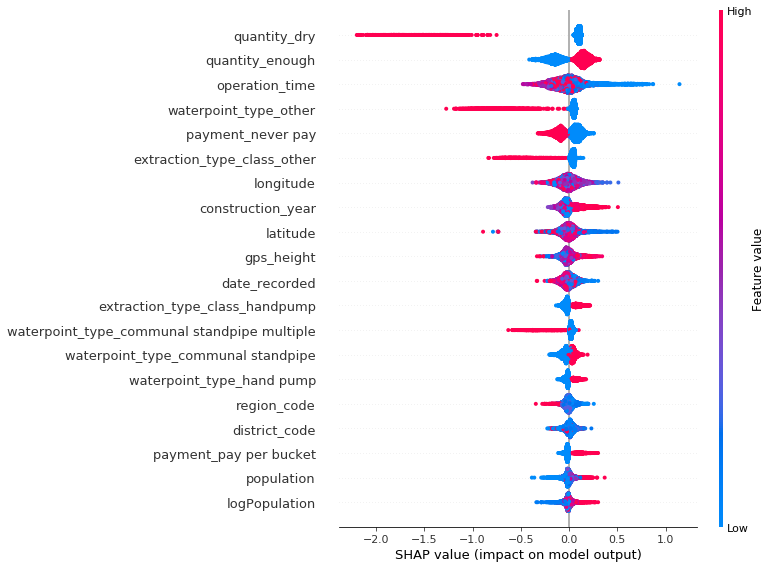

In [ ]:
# functional
shap.summary_plot(shap_values[0], X_valid)

*   For one hot encoded categorical variables, red means "yes" and blue means "no". It is visible that water quantity being dry dramatically reduces the pipe's possibility of being functional
*   Both population and log population seem to affect the model output in a similar manner



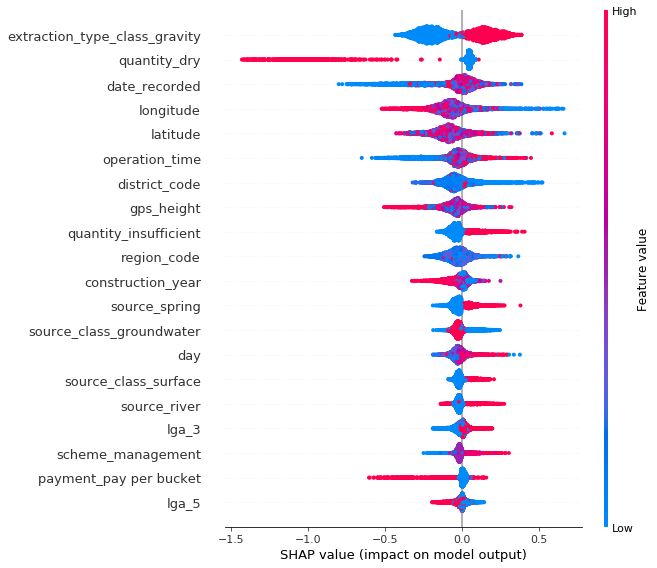

In [ ]:
# functional needs repair
shap.summary_plot(shap_values[1], X_valid)

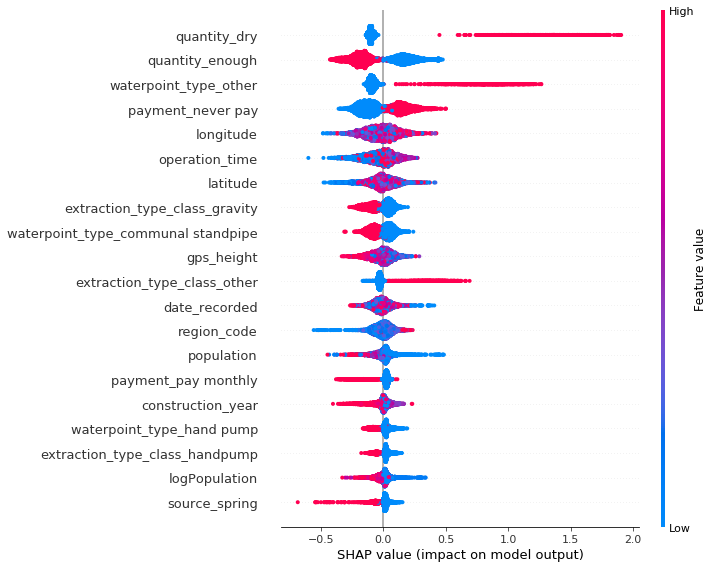

In [ ]:
# non functional
shap.summary_plot(shap_values[2], X_valid)

SHAP Dependence Contribution Plots

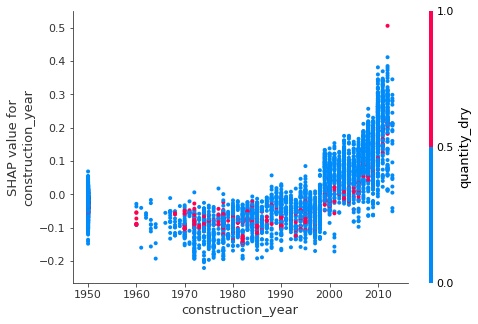

In [ ]:
shap.dependence_plot('construction_year', shap_values[0], X_valid, interaction_index='quantity_dry')

The upward curve suggests that the nearer the construction year, the more likely it is to be functional. Also, the likelihood of recently built pipes to be dry is very low.

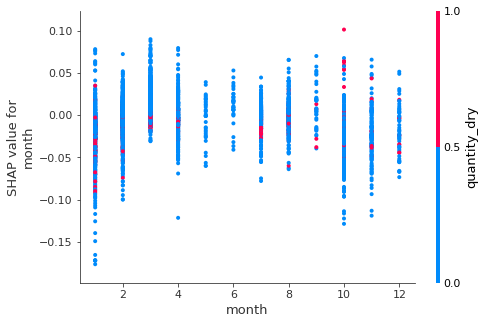

In [ ]:
shap.dependence_plot('month', shap_values[0], X_valid, interaction_index='quantity_dry')

Towards the middle of the year, the pipes are less likely to be dry, probably since Tanzania is reported to have the monsoon season roughly between March-May. Also during this period the tendency for the prediction to be functional is more. This observation may be somehow related to the fact that some pipes may be reported to be non functional only because the well is dried up, and they are now functional due to rain.